In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import torch
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score

import pathlib
from pathlib import Path
import joblib
import os
from datetime import datetime
import uuid
import json
import shutil

from kcm.utils import load_koopman_model, create_discovery_run_dir, save_discovery_params, save_plot, save_artifact, copy_koopman_params_to_discovery

from kcm.koopman_category_model import KoopmanCategoryModel
from kcm.basic_feature_extract import BasicFeatureExtractor
from kcm.discovery import (
    CategoryDiscoveryTrainer,
    train_test_split_indices,
    prep_data_for_discovery,
    check_histograms,
    sup_con_loss,
    BaselineModel,
    HASHHead,
    cluster_acc,
    split_cluster_acc_v1,
    split_cluster_acc_v2,
    create_hash_ids,
    plot_scores
)
from kcm.utils import fix_colab_path, load_koopman_and_discoveries


plt.style.use('default')

In [3]:
pathlib.PosixPath = pathlib.WindowsPath

In [4]:
results = load_koopman_and_discoveries('KCM_20250818_174401_7dc47c3f')

params = results["params"]
print(results['params'][13])

for disc in results["discoveries"]:
    print(f"Found: {disc['path'].name}, Output dim: {disc['params'].get('output_dim')}")

noisy_data: True
Found: discovery_run_20250818_183633_502ee81a, Output dim: 4
Found: discovery_run_20250818_183822_b256b4f9, Output dim: 6
Found: discovery_run_20250818_183952_be5741b1, Output dim: 8


In [6]:
results['params']

['num_cats: 10',
 'num_samples: 500',
 'num_segments: 25',
 'data_path: /content/drive/MyDrive/Colab Notebooks/koopman-category-discovery/data/2-dimensional-systems/dataset_10_class_500_samples.pkl',
 "cats (categories) : ['harmonic_oscillator', 'spring_mass_with_forcing', 'duffing_oscillator', 'van_der_pol_oscillator', 'nonlinear_damped_oscillator', 'nonlinear_spring', 'piecewise_linear_oscillator', 'sine_pendulum', 'sigmoid_pendulum', 'arctangent_oscillator']",
 'normalize_inputs : True',
 'delay_embeddings: 3',
 'total_observables: 8',
 'svd_rank: 8',
 'dmd_rank: 8',
 'MDS_dimension: 10',
 'cluster_method: kmeans',
 'num_cluseters (k): 8',
 'noisy_data: False',
 'noise_std: 0.01',
 'train_classes: range(0, 7)',
 'soft_clustering: True',
 'tau: 0.1']

In [7]:
dimension_mapping = {results['discoveries'][i]['params']['output_dim'] : i for i in range(len(results['discoveries']))}

output_dim = 6
print(output_dim)

kcm_trainer = results['discoveries'][dimension_mapping[output_dim]]['kcm_trainer']
basic_trainer = results['discoveries'][dimension_mapping[output_dim]]['basic_trainer']

discovery_run_dir = results['discoveries'][dimension_mapping[output_dim]]['path']
results_dim = results['discoveries'][dimension_mapping[output_dim]]['params']['output_dim']

assert output_dim == results_dim

6


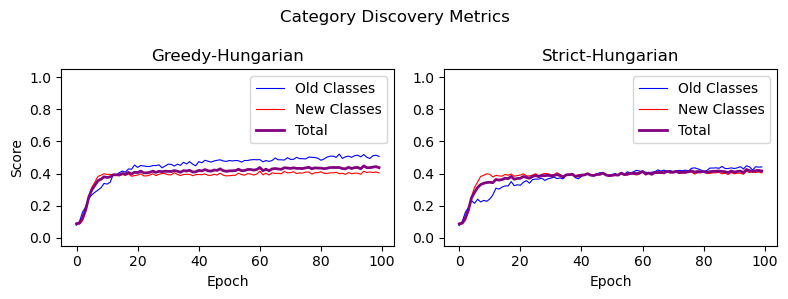

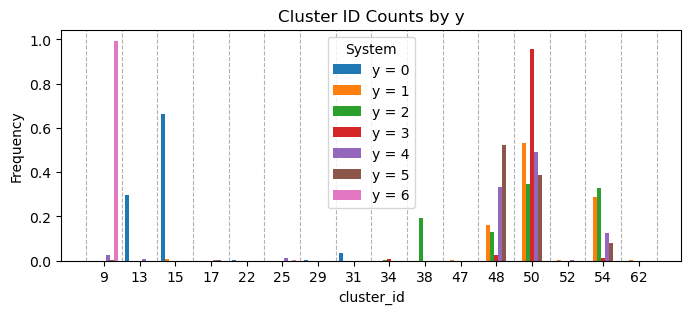

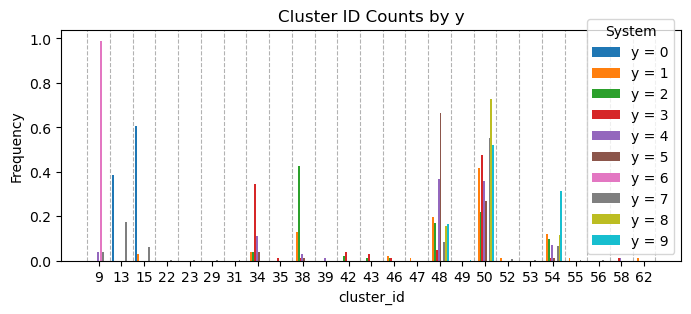

In [26]:
plot_scores(kcm_trainer,index=100)
index = 99
kcm_trainer.plot_hashes(index=index,split_testing=False,show=True,save_dir=discovery_run_dir,base_filename="koopman")

In [24]:
# kcm_trainer.plot_loss(log=True, show=True)
# # save_plot(discovery_run_dir, filename="koopman_loss.png")
# kcm_trainer.plot_unique_hash_count(show=True)
# # save_plot(discovery_run_dir, filename="koopman_unique_hash_count.png")
# kcm_trainer.plot_scores(show=True)
# # save_plot(discovery_run_dir, filename="koopman_scores.png")

# index = 99
# kcm_trainer.plot_hashes(index=index,split_testing=False,show=True,save_dir=discovery_run_dir,base_filename="koopman")
# # kcm_trainer.plot_hashes(index=index,split_testing=False,show=False,save_dir=discovery_run_dir,base_filename="koopman")

In [25]:
# basic_trainer.plot_loss(log=True, show=True)
# # save_plot(discovery_run_dir, filename="basic_loss.png")
# basic_trainer.plot_unique_hash_count(show=True)
# # save_plot(discovery_run_dir, filename="basic_unique_hash_count.png")
# basic_trainer.plot_scores(show=True)
# # save_plot(discovery_run_dir, filename="basic_scores.png")
# basic_trainer.plot_hashes(index=index,split_testing=False,show=True,save_dir=discovery_run_dir,base_filename="basic")
# # basic_trainer.plot_hashes(index=index,split_testing=False,show=False,save_dir=discovery_run_dir,base_filename="basic")